# Q2 Image Colourization using CNNs 

In [ ]:
import hashlib
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import torch
print(torch.__version__)
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
from PIL import Image
from typing import Tuple
import wandb
import torch.optim as optim
import pandas as pd
import json

2.5.1+cu121


/home/mpsamartha/miniconda3/envs/smai-conda/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/mpsamartha/miniconda3/envs/smai-conda/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may

In [24]:
# Using SHA-256 to generate unique seed
username = "m.samartha"
seed = int( hashlib.sha256(username.encode()).hexdigest(),16) % (2**32)
print(seed)
np.random.seed(seed)

def add_username(username = "m.samartha") -> None:
    plt.text(0.95, 0.95, username, ha="right", va="top", transform=plt.gca().transAxes, fontsize=10, color="gray", alpha=0.7)

def add_username_fig(username = "m.samartha", fig=None) -> None:
    if fig is None:
        fig = plt.gcf()
    fig.text(
        1, 1, "m.samartha",
        ha='right', va='top',
        fontsize=10, color='gray', alpha=0.7
    )

2669878649


In [3]:
if torch.cuda.is_available():
    print("GPU is available!")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("GPU not available. Using CPU.")

GPU is available!
Using GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [4]:
cc_path = "Dataset/Q2/color_centroids.npy"

cc = torch.from_numpy(np.load(cc_path)).float()
print(f"Color centroids shape: {cc.shape}")

# print
print(f"Color centroids: {cc}")

Color centroids shape: torch.Size([24, 3])
Color centroids: tensor([[159.6454, 160.7481, 158.4107],
        [ 38.2538,  36.0830,  30.8447],
        [ 99.0412,  97.3504,  88.5621],
        [215.2293, 217.0594, 217.5909],
        [154.7902, 143.6900, 111.6363],
        [ 50.6482,  56.8838,  56.5439],
        [190.6736, 169.7730, 132.7809],
        [166.4135, 197.2941, 227.3716],
        [244.7745, 246.0643, 245.4512],
        [184.3183, 185.3951, 185.4822],
        [131.6868, 138.0750, 141.2190],
        [173.6878,  52.8093,  42.4930],
        [ 77.3270,  78.4903,  67.0091],
        [ 72.3779, 123.0657, 168.6834],
        [ 57.0800,  85.4073, 113.0957],
        [198.0589, 147.2111,  75.4835],
        [ 78.5693,  56.0823,  34.0463],
        [114.6999, 138.7753,  63.2605],
        [ 14.3822,  13.3961,  12.7047],
        [114.6883, 117.4985, 113.7863],
        [219.5874, 200.7235, 168.3714],
        [112.5215,  86.1482,  52.6986],
        [123.1930, 161.3010, 200.2791],
        [142.6007, 1

## 2.1 Model Architecture

Input [B, NIC, 32, 32]

Conv2d -> BN -> ReLU -> MaxPool2d -> [B, NF, 16, 16]

Conv2d -> BN -> ReLU -> MaxPool2d -> [B, 2*NF, 8, 8]

Conv2d -> BN -> ReLU -> MaxPool2d -> [B, 4*NF, 4, 4] 

ConvTranspose2d -> BN -> ReLU -> [B, 2*NF, 8, 8] 

ConvTranspose2d -> BN -> ReLU -> [B, NF, 16, 16]

ConvTranspose2d -> BN -> ReLU -> [B, NC, 32, 32]

Conv2d (classifier) -> [B, NC, 32, 32]

In [5]:
class ColorizationNet(nn.Module):
    """
    A Convolutional Encoder-Decoder Network for Image Colorization.

    This network takes a grayscale image (1 channel) as input and outputs
    logits for 24 color classes for each pixel. The architecture is based on
    the diagram provided in the assignment, consisting of an encoder block
    that downsamples the image and a decoder block that upsamples it
    back to the original resolution.
    """
    
    def __init__(self, nic: int, nf: int, nc: int, kernel_size: int = 3):
        """
        Initializes the network layers.

        Args:
            nic (int): Number of Input Channels (1 for grayscale).
            nf (int): Base number of filters.
            nc (int): Number of output classes (24).
            kernel_size (int): Kernel size for encoder conv layers (3 or 5).
        """
        super(ColorizationNet, self).__init__()

        if kernel_size not in [3, 5]:
            raise ValueError("kernel_size must be either 3 or 5.")

        # Calculate padding to maintain spatial dimensions
        # (kernel_size - 1) // 2 --> (3-1)//2 = 1, (5-1)//2 = 2
        padding = (kernel_size - 1) // 2

        # --- Encoder ---
        # Input: [B, NIC, 32, 32]
        self.encoder1 = nn.Sequential(
            # Conv2d (NIC -> NF), BN, ReLU, MaxPool2d
            nn.Conv2d(nic, nf, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(nf),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # Output: [B, NF, 16, 16]
        )

        self.encoder2 = nn.Sequential(
            # Conv2d (NF -> 2*NF), BN, ReLU, MaxPool2d
            nn.Conv2d(nf, nf * 2, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(nf * 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # Output: [B, 2*NF, 8, 8]
        )

        self.encoder3 = nn.Sequential(
            # Conv2d (2*NF -> 4*NF), BN, ReLU, MaxPool2d
            nn.Conv2d(nf * 2, nf * 4, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(nf * 4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # Output: [B, 4*NF, 4, 4]
        )

        # --- Decoder ---
        # Input: [B, 4*NF, 4, 4]
        self.decoder1 = nn.Sequential(
            # ConvTranspose2d (4*NF -> 2*NF), BN, ReLU
            nn.ConvTranspose2d(nf * 4, nf * 2, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(nf * 2),
            nn.ReLU(inplace=True)
            # Output: [B, 2*NF, 8, 8]
        )

        self.decoder2 = nn.Sequential(
            # ConvTranspose2d (2*NF -> NF), BN, ReLU
            nn.ConvTranspose2d(nf * 2, nf, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(nf),
            nn.ReLU(inplace=True)
            # Output: [B, NF, 16, 16]
        )

        self.decoder3 = nn.Sequential(
            # ConvTranspose2d (NF -> NC), BN, ReLU
            nn.ConvTranspose2d(nf, nc, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(nc),
            nn.ReLU(inplace=True)
            # Output: [B, NC, 32, 32]
        )

        # --- Classifier ---
        # Input: [B, NC, 32, 32]
        self.classifier = nn.Sequential(
            # Conv2d 1x1 (NC -> NC)
            nn.Conv2d(nc, nc, kernel_size=1, stride=1, padding=0)
            # Output: [B, NC, 32, 32]
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Defines the forward pass of the network.

        Args:
            x (torch.Tensor): The input batch of grayscale images, with
                              shape [B, NIC, 32, 32].

        Returns:
            torch.Tensor: The output logits for each color class, with
                          shape [B, NC, 32, 32].
        """
        # --- Encoder Path ---
        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2) # This is the "bottleneck"

        # --- Decoder Path ---
        x4 = self.decoder1(x3)
        x5 = self.decoder2(x4)
        x6 = self.decoder3(x5)

        # --- Classifier ---
        output = self.classifier(x6)

        return output

### Sanity check for output shape

In [6]:
NIC = 1  # 1 input channel (grayscale)
NC = 24  # 24 output classes (color centroids)

# --- Test with kernel_size = 3 ---
NF_k3 = 16  # Base number of filters
KERNEL_SIZE_3 = 3
model_k3 = ColorizationNet(nic=NIC, nf=NF_k3, nc=NC, kernel_size=KERNEL_SIZE_3)

print(f"--- Model with kernel_size={KERNEL_SIZE_3}, nf={NF_k3} ---")

# Create a dummy input tensor
# B (batch_size) = 8
# NIC (channels) = 1
# H, W = 32, 32
dummy_input_k3 = torch.randn(8, NIC, 32, 32)
output_k3 = model_k3(dummy_input_k3)
print(f"\nInput shape: {dummy_input_k3.shape}")
print(f"Output shape: {output_k3.shape}") # Expected: [8, 24, 32, 32]
assert output_k3.shape == (8, NC, 32, 32)

# --- Test with kernel_size = 5 ---
NF_k5 = 32 # Base number of filters
KERNEL_SIZE_5 = 5
model_k5 = ColorizationNet(nic=NIC, nf=NF_k5, nc=NC, kernel_size=KERNEL_SIZE_5)

print(f"\n--- Model with kernel_size={KERNEL_SIZE_5}, nf={NF_k5} ---")
# print(model_k5) # You can uncomment this to see the full model definition

dummy_input_k5 = torch.randn(4, NIC, 32, 32) # Batch size = 4
output_k5 = model_k5(dummy_input_k5)
print(f"\nInput shape: {dummy_input_k5.shape}")
print(f"Output shape: {output_k5.shape}") # Expected: [4, 24, 32, 32]
assert output_k5.shape == (4, NC, 32, 32)

print("\nModel definition is correct and matches diagram specs.")


--- Model with kernel_size=3, nf=16 ---

Input shape: torch.Size([8, 1, 32, 32])
Output shape: torch.Size([8, 24, 32, 32])

--- Model with kernel_size=5, nf=32 ---

Input shape: torch.Size([4, 1, 32, 32])
Output shape: torch.Size([4, 24, 32, 32])

Model definition is correct and matches diagram specs.


## 2.2 Training and Evaluation

### Load and preprocess the data

Testing ColorizationDataset...
Loaded dataset with 50000 training samples.
<class 'torch.Tensor'>
<class 'torch.Tensor'>

Sample 0:
  Input (X) shape: torch.Size([1, 32, 32]), Type: torch.float32
  Label (Y) shape: torch.Size([32, 32]), Type: torch.int64
  Label (Y) min value: 0
  Label (Y) max value: 23

Dataset test passed successfully!


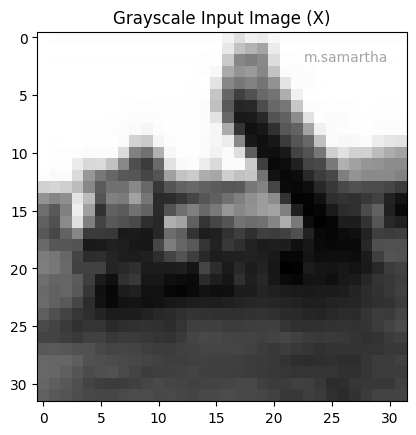

In [7]:
class ColorizationDataset(Dataset):
    """
    A custom PyTorch Dataset for the CIFAR-10 colorization task.

    This dataset handles the required preprocessing on the fly:
    1. Loads the original CIFAR-10 RGB image.
    2. Creates the grayscale version as the model input (X).
    3. Creates the per-pixel 24-class label map as the ground truth (Y)
       by finding the nearest color centroid for each pixel.
    """
    def __init__(self, train: bool = True, centroids_path: str = 'Dataset/Q2/color_centroids.npy'):
        """
        Initializes the dataset.

        Args:
            train (bool): If True, loads the training set. Otherwise, loads the test set.
            centroids_path (str): Path to the .npy file containing the 24 color centroids.
        """
        self.cifar_data = CIFAR10(root='./Dataset/Q2', train=train, download=False)

        # 1. Transform for the model input (X)
        # Converts PIL Image [H, W, C] to Grayscale PIL [H, W]
        # Then converts to Tensor [1, H, W] with values in [0.0, 1.0]
        self.gray_transform = T.Compose([
            T.Resize((32, 32)),
            T.Grayscale(),
            T.ToTensor()
        ])

        # 2. Load centroids for the ground truth (Y)
        try:
            self.centroids = np.load(centroids_path)
        except FileNotFoundError:
            print(f"Error: Centroids file not found at {centroids_path}")
            print("Please place color_centroids.npy in the correct directory.")
            raise
        
        # Reshape centroids for efficient NumPy broadcasting
        # Shape: [24, 3] -> [1, 1, 24, 3]
        self.centroids_broadcastable = self.centroids.reshape(1, 1, 24, 3)

    def __len__(self) -> int:
        """Returns the total number of samples in the dataset."""
        return len(self.cifar_data)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Fetches a single sample from the dataset.

        Args:
            idx (int): The index of the sample.

        Returns:
            tuple:
                - (torch.Tensor): The grayscale input image (Shape: [1, 32, 32]).
                - (torch.Tensor): The ground truth label map (Shape: [32, 32]).
        """
        # Get the original PIL Image
        img_pil, label = self.cifar_data[idx] # We don't need the CIFAR-10 class label

        # --- 1. Create Grayscale Input (X) ---
        # Shape: [1, 32, 32], Range: [0.0, 1.0]
        img_gray_tensor = self.gray_transform(img_pil)

        # --- 2. Create Ground Truth Label Map (Y) ---
        # Convert PIL image to NumPy array
        # Shape: [32, 32, 3], Range: [0, 255], Type: uint8
        img_rgb_np = np.array(img_pil)

        # Reshape for broadcasting against centroids
        # Shape: [32, 32, 3] -> [32, 32, 1, 3]
        img_rgb_broadcastable = img_rgb_np.reshape(32, 32, 1, 3)

        # Calculate L2 distance squared (faster, argmin is the same)
        # Broadcasting: [32, 32, 1, 3] - [1, 1, 24, 3] -> [32, 32, 24, 3]
        distances_sq = np.sum(
            (img_rgb_broadcastable - self.centroids_broadcastable) ** 2,
            axis=3
        )
        # distances_sq shape: [32, 32, 24]

        # Find the index (0-23) of the closest centroid for each pixel
        # Shape: [32, 32]
        label_map = np.argmin(distances_sq, axis=2)

        # Convert label map to a LongTensor (required for CrossEntropyLoss)
        # Shape: [32, 32]
        label_map_tensor = torch.from_numpy(label_map).long()

        if img_gray_tensor.shape != (1, 32, 32):
            print(f"WARNING: Input image at index {idx} has incorrect shape: {img_gray_tensor.shape}")
        # You might need a transform here to resize it
        # e.g., img_gray_tensor = T.Resize((32, 32))(img_gray_tensor)

        # Ensure label is [32, 32]
        if label_map_tensor.shape != (32, 32):
            print(f"WARNING: Label map at index {idx} has incorrect shape: {label_map_tensor.shape}")

        return (img_gray_tensor, label_map_tensor)

try:
    print("Testing ColorizationDataset...")
    # Load a sample from the training set
    train_dataset = ColorizationDataset(train=True)
    print(f"Loaded dataset with {len(train_dataset)} training samples.")
    
    # Get the first sample
    (img_gray, label_map) = train_dataset[2]
    
    print(type(img_gray))
    print(type(label_map))
    # print(type(label))

    print(f"\nSample 0:")
    # print(f"  CIFAR-10 class label: {label}")
    print(f"  Input (X) shape: {img_gray.shape}, Type: {img_gray.dtype}")
    print(f"  Label (Y) shape: {label_map.shape}, Type: {label_map.dtype}")
    print(f"  Label (Y) min value: {label_map.min()}")
    print(f"  Label (Y) max value: {label_map.max()}")

    # Check shapes and types
    assert img_gray.shape == (1, 32, 32)
    assert img_gray.dtype == torch.float32
    assert label_map.shape == (32, 32)
    assert label_map.dtype == torch.int64
    assert label_map.min() >= 0
    assert label_map.max() <= 23

    plt.imshow(img_gray.squeeze(), cmap='gray')
    plt.title("Grayscale Input Image (X)")
    add_username()

    print("\nDataset test passed successfully!")

except FileNotFoundError:
    print("\nDataset test skipped: 'color_centroids.npy' not found.")
except Exception as e:
    print(f"\nDataset test failed: {e}")


### Utility function to convert label map to RGB image 

Testing convert_label_to_rgb...
Loaded centroids with shape: (24, 3)
Input label map shape: torch.Size([32, 32])
Output RGB image shape: (32, 32, 3), Type: uint8
Pixel mapping test passed.

Test passed successfully!


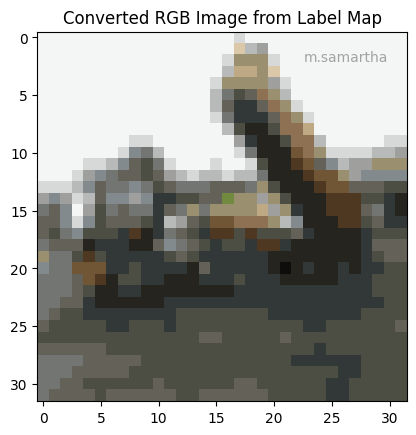

In [8]:
def convert_label_to_rgb(label_map: torch.Tensor, centroids: np.ndarray) -> np.ndarray:
    """
    Converts a 2D label map (with class indices) back to a 3D RGB image.

    Args:
        label_map (torch.Tensor): A 2D tensor of shape [H, W] containing
                                  class indices (0-23).
        centroids (np.ndarray): The centroid array, shape [24, 3].

    Returns:
        np.ndarray: A 3D RGB image of shape [H, W, 3] with uint8 values.
    """
    # Ensure label_map is on the CPU and is a NumPy array
    if label_map.is_cuda:
        label_map = label_map.cpu()
    label_map_np = label_map.numpy().astype(int)
    
    # Use NumPy's powerful fancy indexing to "look up" the color
    # for each pixel index in the label map.
    rgb_image = centroids[label_map_np]
    
    # Ensure the output is uint8
    return rgb_image.astype(np.uint8)

try:
    print("Testing convert_label_to_rgb...")
    
    # 1. Load centroids
    test_centroids = np.load('Dataset/Q2/color_centroids.npy')
    print(f"Loaded centroids with shape: {test_centroids.shape}")

    # 2. Create a dummy label map
    # Shape: [32, 32], with values from 0 to 23
    dummy_labels_tensor = label_map
    
    # 3. Convert
    rgb_image = convert_label_to_rgb(dummy_labels_tensor, test_centroids)
    
    print(f"Input label map shape: {dummy_labels_tensor.shape}")
    print(f"Output RGB image shape: {rgb_image.shape}, Type: {rgb_image.dtype}")
    
    # Check shape and type
    assert rgb_image.shape == (32, 32, 3)
    assert rgb_image.dtype == np.uint8

    plt.imshow(rgb_image)
    plt.title("Converted RGB Image from Label Map")
    add_username()
    
    # Check if a known pixel maps correctly
    test_centroids[5] = [10, 20, 30] # Force a known value
    dummy_labels_tensor[0, 0] = 5
    rgb_image = convert_label_to_rgb(dummy_labels_tensor, test_centroids)
    
    assert np.array_equal(rgb_image[0, 0], [10, 20, 30])
    print("Pixel mapping test passed.")
    
    print("\nTest passed successfully!")

except FileNotFoundError:
    print("\nTest skipped: 'color_centroids.npy' not found.")
except Exception as e:
    print(f"\nTest failed: {e}")

### Training and Evaluation Loop

In [9]:
def train_and_validate(config):
    """
    Main training and validation function.
    Accepts a configuration dictionary or wandb.config object.
    """

    # --- 1. Initialize Weights & Biases ---
    wandb.init(project="2023102038-A4-Q2", config=config)
    config = wandb.config  # Make sure we use the updated config from wandb
    torch.manual_seed(config.seed)

    print("Starting training run with configuration:")
    print(config)

    # --- 2. Setup (Device, Data, Model, Loss, Optimizer) ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load centroids (needed for logging images)
    try:
        centroids = np.load(config.centroids_path)
    except FileNotFoundError:
        print(f"Fatal Error: Centroids file not found at {config.centroids_path}")
        print("Please provide the color_centroids.npy file.")
        wandb.finish()
        return

    # --- Data ---
    print("Loading datasets...")
    train_dataset = ColorizationDataset(train=True, centroids_path=config.centroids_path)
    val_dataset = ColorizationDataset(train=False, centroids_path=config.centroids_path)

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    print("Datasets loaded.")

    # --- Model ---
    model = ColorizationNet(
        nic=config.nic,
        nf=config.nf,
        nc=config.nc,
        kernel_size=config.kernel_size
    ).to(device)

    wandb.watch(model, log="all", log_freq=100)

    # --- Loss and Optimizer ---
    criterion = nn.CrossEntropyLoss()

    if config.optimizer == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    elif config.optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.9)
    else:
        raise ValueError(f"Unknown optimizer: {config.optimizer}")

    # --- 3. Training Loop ---
    print("Starting training...")
    best_val_loss = float('inf')

    for epoch in range(config.epochs):
        # --- Training Phase ---
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # --- Validation Phase ---
        model.eval()
        val_loss = 0.0
        total_pixels = 0
        correct_pixels = 0
        correct_top_4 = 0
        example_images = []

        with torch.no_grad():
            for i, (inputs, labels) in enumerate(val_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # --- Per-pixel accuracy ---
                output_map = torch.argmax(outputs, dim=1)
                correct_pixels += (output_map == labels).sum().item()
                total_pixels += labels.numel()

                top_4_indices = torch.topk(outputs, k=4, dim=1).indices
                correct_top_4 += (top_4_indices == labels.unsqueeze(1)).any(dim=1).sum().item()

                # --- Log example images (first batch only) ---
                if i == 0:
                    img_gray_pil = T.ToPILImage()(inputs[0].cpu())
                    img_pred_rgb = convert_label_to_rgb(output_map[0], centroids)
                    img_gt_rgb = convert_label_to_rgb(labels[0], centroids)

                    example_images.append(wandb.Image(
                        img_gray_pil, caption=f"Epoch {epoch}: Input (Grayscale)"
                    ))
                    example_images.append(wandb.Image(
                        img_pred_rgb, caption=f"Epoch {epoch}: Predicted Color"
                    ))
                    example_images.append(wandb.Image(
                        img_gt_rgb, caption=f"Epoch {epoch}: Ground Truth Color"
                    ))

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct_pixels / total_pixels
        val_top4_accuracy = correct_top_4 / total_pixels

        # --- Log metrics to wandb ---
        wandb.log({
            "epoch": epoch,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "val_accuracy": val_accuracy,
            "val_top4_accuracy": val_top4_accuracy,
            "example_images": example_images
        })

        print(f"Epoch [{epoch+1}/{config.epochs}] | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val Acc: {val_accuracy:.4f} | "
              f"Val Top-4 Acc: {val_top4_accuracy:.4f} | ")

        # --- Save Best Model ---
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            model_path = "best_model.pth"
            torch.save(model.state_dict(), model_path)
            wandb.save(model_path)
            print(f"New best model saved to {model_path} (Val Loss: {best_val_loss:.4f})")

    print("Training complete.")

    model.eval() # Set the model to evaluation mode

    total_pixels = 0
    correct_pixels = 0
    correct_top4 = 0
    print("Calculating accuracy on train set images...")

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)  # Shape: [B, 24, 32, 32]
        output_map = torch.argmax(outputs, dim=1)  # Shape: [B, 32, 32]
        correct_pixels += (output_map == labels).sum().item()
        total_pixels += labels.numel()

        # Get top 4 predicted classes for each pixel
        top4_indices = torch.topk(outputs, k=4, dim=1).indices
        correct_top4 += (top4_indices == labels.unsqueeze(1)).any(dim=1).sum().item()

    if total_pixels == 0:
        print("No pixels to evaluate.")
        accuracy = 0.0
        top4_accuracy = 0.0

    accuracy = correct_pixels / total_pixels
    top4_accuracy = correct_top4 / total_pixels
    print(f"Per-pixel accuracy on training set: {accuracy:.4f}")
    print(f"Top-4 accuracy on training set: {top4_accuracy:.4f}")
    wandb.log({"train_set_accuracy": accuracy,
                "train_set_top4_accuracy": top4_accuracy})
    
    # --- 4. 10 Example colorization ---
    indices = random.sample(range(len(train_dataset)), 10)
    final_images = {}
    for idx in indices:
        post_train_examples = []
        img_gray, label_map = train_dataset[idx]
        label_map = label_map.to(device)
        img_gray_batch = img_gray.unsqueeze(0).to(device)  # Add batch dimension

        with torch.no_grad():
            output = model(img_gray_batch)
            output_map = torch.argmax(output, dim=1).squeeze(0)  # Remove batch dimension

        img_gray_pil = T.ToPILImage()(img_gray.cpu())
        img_pred_rgb = convert_label_to_rgb(output_map, centroids)
        img_gt_rgb = convert_label_to_rgb(label_map, centroids)

        post_train_examples.append(wandb.Image(
            img_gray_pil, caption=f"Index {idx}: Input (Grayscale)"
        ))
        post_train_examples.append(wandb.Image(
            img_pred_rgb, caption=f"Index {idx}: Predicted Color" 
        ))
        post_train_examples.append(wandb.Image(
            img_gt_rgb, caption=f"Index {idx}: Ground Truth Color"
        ))

        wandb.log({"post_train_example_"+str(idx): post_train_examples})
        final_images[idx] = post_train_examples

    wandb.finish()
    return final_images

In [10]:
config_defaults = {
    'learning_rate': 1e-3,
    'batch_size': 64,
    'nf': 32,
    'kernel_size': 3,
    'optimizer': 'adam',
    'epochs': 25,
    'nic': 1,
    'nc': 24,
    'centroids_path': 'Dataset/Q2/color_centroids.npy',
    'seed': 42
}

final_images = train_and_validate(config_defaults) 

wandb: Currently logged in as: m-samartha (m-samartha-iiit-hyderabad) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Starting training run with configuration:
{'learning_rate': 0.001, 'batch_size': 64, 'nf': 32, 'kernel_size': 3, 'optimizer': 'adam', 'epochs': 25, 'nic': 1, 'nc': 24, 'centroids_path': 'Dataset/Q2/color_centroids.npy', 'seed': 42}
Using device: cuda
Loading datasets...
Datasets loaded.
Starting training...
Epoch [1/25] | Train Loss: 2.1013 | Val Loss: 1.8402 | Val Acc: 0.3537 | Val Top-4 Acc: 0.7768 | 
New best model saved to best_model.pth (Val Loss: 1.8402)
Epoch [2/25] | Train Loss: 1.8146 | Val Loss: 1.7930 | Val Acc: 0.3634 | Val Top-4 Acc: 0.7917 | 
New best model saved to best_model.pth (Val Loss: 1.7930)
Epoch [3/25] | Train Loss: 1.7613 | Val Loss: 1.7278 | Val Acc: 0.3827 | Val Top-4 Acc: 0.8094 | 
New best model saved to best_model.pth (Val Loss: 1.7278)
Epoch [4/25] | Train Loss: 1.7333 | Val Loss: 1.7080 | Val Acc: 0.3856 | Val Top-4 Acc: 0.8123 | 
New best model saved to best_model.pth (Val Loss: 1.7080)
Epoch [5/25] | Train Loss: 1.7188 | Val Loss: 1.6779 | Val Acc: 0.3

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_set_accuracy,▁
train_set_top4_accuracy,▁
val_accuracy,▁▂▄▅▆▆▆▇▇▇▇▆▇▆▆▇▅▇▇██▇▆▇▇
val_loss,█▇▅▄▃▃▃▂▂▂▂▃▂▂▃▂▄▁▂▁▁▂▃▂▂
val_top4_accuracy,▁▃▄▅▆▆▆▇▇▇▇▆▇▇▆▇▅█▇███▆▇█
epoch,24
train_loss,1.61474
train_set_accuracy,0.41615
train_set_top4_accuracy,0.84187


In [28]:
def plot_final_images(final_images):
    """
    Plots grayscale, predicted, and ground truth color images
    returned by train_and_validate(), with fixed column captions.
    """
    num_examples = len(final_images)
    col_titles = ["Input (Grayscale)", "Predicted Color", "Ground Truth Color"]

    fig, axes = plt.subplots(num_examples, 3, figsize=(10, num_examples * 3))

    if num_examples == 1:
        axes = [axes]  # handle single-row case

    for i, (idx, image_list) in enumerate(final_images.items()):
        for j, item in enumerate(image_list):
            # Handle wandb.Image, dict, or plain PIL/numpy
            if hasattr(item, "image"):
                img = item.image
            elif isinstance(item, dict):
                img = item.get("image", item)
            else:
                img = item

            if not isinstance(img, Image.Image):
                img = Image.fromarray(img)

            axes[i][j].imshow(img)
            axes[i][j].axis("off")

            # Set fixed column titles for the first row only
            if i == 0:
                axes[i][j].set_title(col_titles[j], fontsize=11, fontweight="bold")

    plt.tight_layout()
    add_username_fig(fig=fig)
    plt.show()

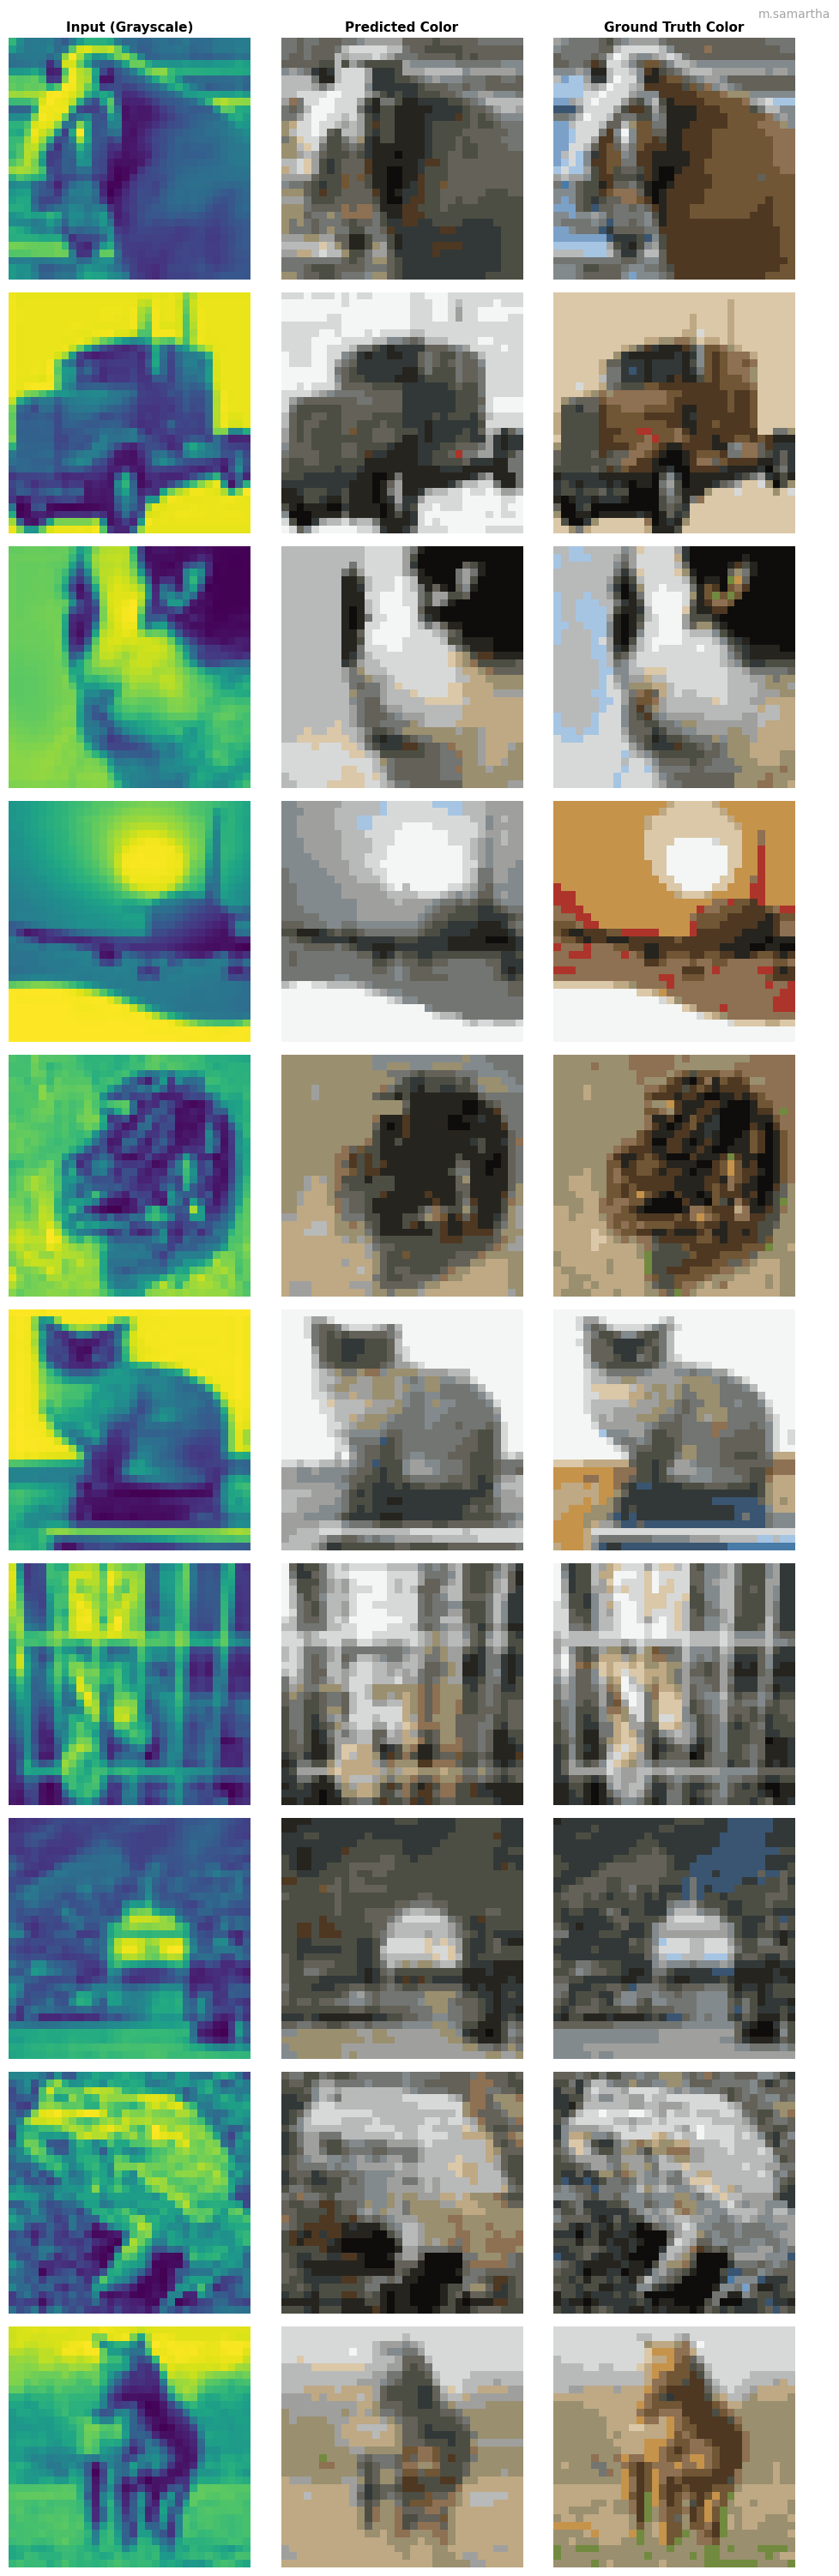

In [29]:
plot_final_images(final_images)

## 2.3 Analytical Questions

### **Assumptions**

1. Standard Conv2d (Layers 1, 2, 3): To maintain spatial dimensions before pooling (e.g., 32x32 -> 32x32), we assume a kernel_size=3, stride=1, and padding=1.

2. MaxPool2d: To halve the spatial dimensions (e.g., 32x32 -> 16x16), we assume a kernel_size=2 and stride=2.

3. ConvTranspose2d (Layers 4, 5, 6): To double the spatial dimensions (e.g., 4x4 -> 8x8), we assume a kernel_size=2, stride=2, and padding=0.

4. Classifier Conv2d (Layer 7): This layer maps channels without changing spatial size (32x32 -> 32x32). This is typically a 1x1 convolution. We assume a kernel_size=1, stride=1, and padding=0.

5. Parameters: We will ignore all bias parameters and parameters from BatchNorm layers.

### **A) 32x32**

#### **1. Number of weights**

| Layer | Type | Formula | Weights |
|---:|---|---|---:|
| L1 | Conv2d (3×3) | NIC × NF × 3 × 3 | 9·NIC·NF |
| L2 | Conv2d (3×3) | NF × (2·NF) × 3 × 3 | 18·NF² |
| L3 | Conv2d (3×3) | (2·NF) × (4·NF) × 3 × 3 | 72·NF² |
| L4 | ConvT (2×2) | (4·NF) × (2·NF) × 2 × 2 | 32·NF² |
| L5 | ConvT (2×2) | (2·NF) × NF × 2 × 2 | 8·NF² |
| L6 | ConvT (2×2) | NF × NC × 2 × 2 | 4·NF·NC |
| L7 | Conv2d (1×1) | NC × NC × 1 × 1 | NC² |

Total Weights:

$W_{total}$=9⋅NIC⋅NF+130⋅NF²+4⋅NF⋅NC+NC²

==================================================================================================

#### **2. Number of outputs**

| Layer | Output Shape | Activations |
|---:|---|---:|
| L1 | [NF, 16, 16] | 256·NF |
| L2 | [2NF, 8, 8] | 128·NF |
| L3 | [4NF, 4, 4] | 64·NF |
| L4 | [2NF, 8, 8] | 128·NF |
| L5 | [NF, 16, 16] | 256·NF |
| L6 | [NC, 32, 32] | 1024·NC |
| L7 | [NC, 32, 32] | 1024·NC |

Total Outputs:

$O_{total​}$=832⋅NF+2048⋅NC

==================================================================================================

#### **3. Number of connections**

| Layer | Formula                | Connections     |
|:------|:------------------------|:----------------|
| L1    | (9·NIC·NF) × (32×32)   | 9216·NIC·NF     |
| L2    | (18·NF²) × (16×16)     | 4608·NF²        |
| L3    | (72·NF²) × (8×8)       | 4608·NF²        |
| L4    | (32·NF²) × (4×4)       | 512·NF²         |
| L5    | (8·NF²) × (8×8)        | 512·NF²         |
| L6    | (4·NF·NC) × (16×16)    | 1024·NF·NC      |
| L7    | (NC²) × (32×32)        | 1024·NC²        |

Total Connections:

$C_{total}$=9216·NIC·NF+10240·NF²+1024·NF·NC+1024·NC²

==================================================================================================

### **B) 64x64**

#### **1. Number of weights**
Weights are independent of input spatial size.

$W_{total\_64}$=9⋅$NIC$⋅$NF$+130⋅$NF^{2}$+4⋅$NF$⋅$NC$+$NC^{2}$

==================================================================================================

#### **2. Number of outputs**

Since the spatial dimensions double at each layer due to pooling and upsampling, the output total output activations will be 4 times that of the 32x32 case.

$O_{total\_64}$=4⋅(832⋅$NF$+2048⋅$NC$)=3328⋅$NF$+8192⋅$NC$

==================================================================================================

#### **3. Number of connections**

Since the spatial dimensions double at each layer due to pooling and upsampling, the total connections will be 4 times that of the 32x32 case.

$C_{total\_64}$=4⋅(9216·$NIC$·$NF$+10240·$NF^{2}$+1024·$NF$·$NC$+1024·$NC^{2}$)=

36864·$NIC$·$NF$+40960·$NF^{2}$+4096·$NF$·$NC$+4096·$NC^{2}$

==================================================================================================

## 2.4 Hyperparameter Tuning

### Modified Training Loop

In [45]:
def train_and_validate_hpt(config):
    """
    Main training and validation function.
    Accepts a configuration dictionary or wandb.config object.
    """
    # --- 1. Setup (Device, Data, Model, Loss, Optimizer) ---
    torch.manual_seed(config.seed)

    print("Starting training run with configuration:")
    print(config)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load centroids (needed for logging images)
    try:
        centroids = np.load(config.centroids_path)
    except FileNotFoundError:
        print(f"Fatal Error: Centroids file not found at {config.centroids_path}")
        print("Please provide the color_centroids.npy file.")
        wandb.finish()
        return

    # --- Data ---
    print("Loading datasets...")
    train_dataset = ColorizationDataset(train=True, centroids_path=config.centroids_path)
    val_dataset = ColorizationDataset(train=False, centroids_path=config.centroids_path)

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    print("Datasets loaded.")

    # --- Model ---
    model = ColorizationNet(
        nic=config.nic,
        nf=config.nf,
        nc=config.nc,
        kernel_size=config.kernel_size
    ).to(device)

    wandb.watch(model, log="all", log_freq=100)

    # --- Loss and Optimizer ---
    criterion = nn.CrossEntropyLoss()

    if config.optimizer == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    elif config.optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.9)
    else:
        raise ValueError(f"Unknown optimizer: {config.optimizer}")

    # --- 2. Training Loop ---
    print("Starting training...")
    best_val_loss = float('inf')
    best_val_top4 = float(0.0)

    for epoch in range(config.epochs):
        # --- Training Phase ---
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # --- Validation Phase ---
        model.eval()
        val_loss = 0.0
        total_pixels = 0
        correct_pixels = 0
        correct_top_4 = 0
        example_images = []

        with torch.no_grad():
            for i, (inputs, labels) in enumerate(val_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # --- Per-pixel accuracy ---
                output_map = torch.argmax(outputs, dim=1)
                correct_pixels += (output_map == labels).sum().item()
                total_pixels += labels.numel()

                top_4_indices = torch.topk(outputs, k=4, dim=1).indices
                correct_top_4 += (top_4_indices == labels.unsqueeze(1)).any(dim=1).sum().item()

                # --- Log example images (first batch only) ---
                if i == 0:
                    img_gray_pil = T.ToPILImage()(inputs[0].cpu())
                    img_pred_rgb = convert_label_to_rgb(output_map[0], centroids)
                    img_gt_rgb = convert_label_to_rgb(labels[0], centroids)

                    example_images.append(wandb.Image(
                        img_gray_pil, caption=f"Epoch {epoch}: Input (Grayscale)"
                    ))
                    example_images.append(wandb.Image(
                        img_pred_rgb, caption=f"Epoch {epoch}: Predicted Color"
                    ))
                    example_images.append(wandb.Image(
                        img_gt_rgb, caption=f"Epoch {epoch}: Ground Truth Color"
                    ))

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct_pixels / total_pixels
        val_top4_accuracy = correct_top_4 / total_pixels

        # --- Log metrics to wandb ---
        wandb.log({
            "epoch": epoch,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "val_accuracy": val_accuracy,
            "val_top4_accuracy": val_top4_accuracy,
            "example_images": example_images
        })

        print(f"Epoch [{epoch+1}/{config.epochs}] | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val Acc: {val_accuracy:.4f} | "
              f"Val Top-4 Acc: {val_top4_accuracy:.4f} | ")

        # --- Save Best Model ---
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            wandb.run.summary["best_val_loss"] = best_val_loss

        if val_top4_accuracy > best_val_top4:
            best_val_top4 = val_top4_accuracy
            wandb.run.summary["best_val_top4_accuracy"] = best_val_top4

    print("Training complete.")

    model.eval() # Set the model to evaluation mode

    total_pixels = 0
    correct_pixels = 0
    correct_top4 = 0
    print("Calculating accuracy on train set images...")

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)  # Shape: [B, 24, 32, 32]
        output_map = torch.argmax(outputs, dim=1)  # Shape: [B, 32, 32]
        correct_pixels += (output_map == labels).sum().item()
        total_pixels += labels.numel()

        # Get top 4 predicted classes for each pixel
        top4_indices = torch.topk(outputs, k=4, dim=1).indices
        correct_top4 += (top4_indices == labels.unsqueeze(1)).any(dim=1).sum().item()

    if total_pixels == 0:
        print("No pixels to evaluate.")
        accuracy = 0.0
        top4_accuracy = 0.0

    accuracy = correct_pixels / total_pixels
    top4_accuracy = correct_top4 / total_pixels
    print(f"Per-pixel accuracy on training set: {accuracy:.4f}")
    print(f"Top-4 accuracy on training set: {top4_accuracy:.4f}")
    wandb.log({"train_set_accuracy": accuracy,
                "train_set_top4_accuracy": top4_accuracy})
    
    wandb.run.summary["train_set_top4_accuracy"] = top4_accuracy

### Sweep Configuration

In [46]:
# Define your sweep configuration
sweep_config = {
    'name': 'cifar-colorization-sweep',
    'method': 'bayes',  # 'grid', 'random', or 'bayes'
    'metric': {
        'name': 'val_top4_accuracy',
        'goal': 'maximize'   
    },
    'parameters': {
        'learning_rate': {
            'values': [1e-4, 3e-4, 1e-3, 3e-3]
        },
        'batch_size': {
            'values': [32, 64, 128]
        },
        'nf': {
            'values': [8, 16, 32]
        },
        'kernel_size': {
            'values': [3, 5]
        },
        'optimizer': {
            'values': ['adam', 'sgd']
        },
        # --- Add non-sweep parameters here ---
        'epochs': {'value': 25},
        'nic': {'value': 1},
        'nc': {'value': 24},
        'centroids_path': {'value': 'Dataset/Q2/color_centroids.npy'},
        'seed': {'value': 42}
    }
}

### Training loop wrapper

In [47]:
def run_sweep_iteration():
    """
    A wrapper function to be called by wandb.agent.
    This function initializes wandb, sets up static vars,
    and calls the main training logic.
    """
    # 1. Initialize a new wandb run
    run = wandb.init()
    
    # 2. Get the config for this run
    config = wandb.config

    # 3. Call the main training function
    try:
        train_and_validate_hpt(config)
    except Exception as e:
        print(f"Run failed with error: {e}")
        wandb.log({"error": str(e)}) # Log the error
    finally:
        # 5. Finish the run
        wandb.finish()

### Sweep

In [ ]:
# Create the Sweep (this returns the Sweep ID)
sweep_id = wandb.sweep(sweep_config, project="2023102038-A4-Q2-sweeps")

print(f"Sweep created! Sweep ID: {sweep_id}")
print("Starting agent...")

# Run the Agent (this will execute 'run_sweep_iteration' 40 times)
wandb.agent(sweep_id, function=run_sweep_iteration, count=40)

print("Sweep complete!")

In [ ]:
# running for a few more trials

sweep_id = "gf27u4jf"  # your sweep ID
print(f"Sweep ID: {sweep_id}")
print("Starting agent...")

# Run the Agent (this will execute 'run_sweep_iteration' for remaining 13 times)
wandb.agent(sweep_id, function=run_sweep_iteration, count=13)

print("Sweep complete!")

Sweep ID: gf27u4jf
Starting agent...


wandb: Agent Starting Run: f9uow00c with config:
wandb: 	batch_size: 128
wandb: 	centroids_path: Dataset/Q2/color_centroids.npy
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.003
wandb: 	nc: 24
wandb: 	nf: 32
wandb: 	nic: 1
wandb: 	optimizer: adam
wandb: 	seed: 42
wandb: Currently logged in as: m-samartha (m-samartha-iiit-hyderabad) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Starting training run with configuration:
{'batch_size': 128, 'centroids_path': 'Dataset/Q2/color_centroids.npy', 'epochs': 25, 'kernel_size': 5, 'learning_rate': 0.003, 'nc': 24, 'nf': 32, 'nic': 1, 'optimizer': 'adam', 'seed': 42}
Using device: cuda
Loading datasets...
Datasets loaded.
Starting training...
Epoch [1/25] | Train Loss: 2.0108 | Val Loss: 1.7398 | Val Acc: 0.3789 | Val Top-4 Acc: 0.8070 | 
Epoch [2/25] | Train Loss: 1.6820 | Val Loss: 1.6296 | Val Acc: 0.4065 | Val Top-4 Acc: 0.8385 | 
Epoch [3/25] | Train Loss: 1.6021 | Val Loss: 1.6051 | Val Acc: 0.4132 | Val Top-4 Acc: 0.8459 | 
Epoch [4/25] | Train Loss: 1.5611 | Val Loss: 1.5742 | Val Acc: 0.4162 | Val Top-4 Acc: 0.8583 | 
Epoch [5/25] | Train Loss: 1.5383 | Val Loss: 1.5364 | Val Acc: 0.4332 | Val Top-4 Acc: 0.8665 | 
Epoch [6/25] | Train Loss: 1.5037 | Val Loss: 1.5109 | Val Acc: 0.4384 | Val Top-4 Acc: 0.8727 | 
Epoch [7/25] | Train Loss: 1.4937 | Val Loss: 1.4831 | Val Acc: 0.4455 | Val Top-4 Acc: 0.8807 | 
Epoc

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_set_accuracy,▁
train_set_top4_accuracy,▁
val_accuracy,▁▃▃▄▅▅▆▅▃▆▅▆▃▄▇▆▅▇▇▅▆▇█▇▇
val_loss,█▆▅▅▄▄▃▃▅▃▄▂▅▅▂▂▄▂▂▄▃▂▁▂▃
val_top4_accuracy,▁▃▄▅▅▆▆▆▅▆▆▇▄▆▇▇▅▇▇▆▆▇█▇▇
best_val_loss,1.37684
best_val_top4_accuracy,0.90516
epoch,24
train_loss,1.37678


wandb: Agent Starting Run: b150ffdm with config:
wandb: 	batch_size: 64
wandb: 	centroids_path: Dataset/Q2/color_centroids.npy
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.003
wandb: 	nc: 24
wandb: 	nf: 32
wandb: 	nic: 1
wandb: 	optimizer: adam
wandb: 	seed: 42


Starting training run with configuration:
{'batch_size': 64, 'centroids_path': 'Dataset/Q2/color_centroids.npy', 'epochs': 25, 'kernel_size': 5, 'learning_rate': 0.003, 'nc': 24, 'nf': 32, 'nic': 1, 'optimizer': 'adam', 'seed': 42}
Using device: cuda
Loading datasets...
Datasets loaded.
Starting training...
Epoch [1/25] | Train Loss: 1.9213 | Val Loss: 1.7079 | Val Acc: 0.3830 | Val Top-4 Acc: 0.8182 | 
Epoch [2/25] | Train Loss: 1.6703 | Val Loss: 1.6801 | Val Acc: 0.3856 | Val Top-4 Acc: 0.8374 | 
Epoch [3/25] | Train Loss: 1.6001 | Val Loss: 1.7465 | Val Acc: 0.3772 | Val Top-4 Acc: 0.8049 | 
Epoch [4/25] | Train Loss: 1.5649 | Val Loss: 1.5633 | Val Acc: 0.4208 | Val Top-4 Acc: 0.8612 | 
Epoch [5/25] | Train Loss: 1.5527 | Val Loss: 1.4867 | Val Acc: 0.4497 | Val Top-4 Acc: 0.8790 | 
Epoch [6/25] | Train Loss: 1.5220 | Val Loss: 1.6758 | Val Acc: 0.3898 | Val Top-4 Acc: 0.8300 | 
Epoch [7/25] | Train Loss: 1.5105 | Val Loss: 1.5390 | Val Acc: 0.4263 | Val Top-4 Acc: 0.8685 | 
Epoch

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_set_accuracy,▁
train_set_top4_accuracy,▁
val_accuracy,▁▂▁▄▆▂▄▆▅▅▆▆▆▆▆▆▇▇▆▆▅▇█▇█
val_loss,▇▇█▅▃▇▄▃▃▃▃▃▃▃▂▃▂▂▃▃▄▁▁▁▁
val_top4_accuracy,▂▃▁▅▆▃▅▆▆▆▆▆▇▇▇▆▇▇▇▇▅████
best_val_loss,1.37202
best_val_top4_accuracy,0.90544
epoch,24
train_loss,1.36092


wandb: Agent Starting Run: hv09va2m with config:
wandb: 	batch_size: 128
wandb: 	centroids_path: Dataset/Q2/color_centroids.npy
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.003
wandb: 	nc: 24
wandb: 	nf: 32
wandb: 	nic: 1
wandb: 	optimizer: adam
wandb: 	seed: 42


Starting training run with configuration:
{'batch_size': 128, 'centroids_path': 'Dataset/Q2/color_centroids.npy', 'epochs': 25, 'kernel_size': 5, 'learning_rate': 0.003, 'nc': 24, 'nf': 32, 'nic': 1, 'optimizer': 'adam', 'seed': 42}
Using device: cuda
Loading datasets...
Datasets loaded.
Starting training...
Epoch [1/25] | Train Loss: 2.0111 | Val Loss: 1.7355 | Val Acc: 0.3800 | Val Top-4 Acc: 0.8086 | 
Epoch [2/25] | Train Loss: 1.6824 | Val Loss: 1.6232 | Val Acc: 0.4084 | Val Top-4 Acc: 0.8404 | 
Epoch [3/25] | Train Loss: 1.6020 | Val Loss: 1.5864 | Val Acc: 0.4177 | Val Top-4 Acc: 0.8528 | 
Epoch [4/25] | Train Loss: 1.5613 | Val Loss: 1.6007 | Val Acc: 0.4083 | Val Top-4 Acc: 0.8512 | 
Epoch [5/25] | Train Loss: 1.5386 | Val Loss: 1.5323 | Val Acc: 0.4343 | Val Top-4 Acc: 0.8670 | 
Epoch [6/25] | Train Loss: 1.5043 | Val Loss: 1.5075 | Val Acc: 0.4397 | Val Top-4 Acc: 0.8735 | 
Epoch [7/25] | Train Loss: 1.4945 | Val Loss: 1.4799 | Val Acc: 0.4462 | Val Top-4 Acc: 0.8813 | 
Epoc

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_set_accuracy,▁
train_set_top4_accuracy,▁
val_accuracy,▁▃▄▃▅▅▆▆▄▆▄▆▄▄▇▆▅▇▆▅▆▇██▇
val_loss,█▆▅▅▄▄▃▃▄▃▅▃▅▅▂▃▄▂▃▄▃▂▁▁▃
val_top4_accuracy,▁▃▄▄▅▆▆▆▅▆▆▆▅▆▇▇▅▇▇▆▆▇██▇
best_val_loss,1.37661
best_val_top4_accuracy,0.90568
epoch,24
train_loss,1.37865


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: crdyqxpp with config:
wandb: 	batch_size: 64
wandb: 	centroids_path: Dataset/Q2/color_centroids.npy
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.003
wandb: 	nc: 24
wandb: 	nf: 16
wandb: 	nic: 1
wandb: 	optimizer: adam
wandb: 	seed: 42


Starting training run with configuration:
{'batch_size': 64, 'centroids_path': 'Dataset/Q2/color_centroids.npy', 'epochs': 25, 'kernel_size': 5, 'learning_rate': 0.003, 'nc': 24, 'nf': 16, 'nic': 1, 'optimizer': 'adam', 'seed': 42}
Using device: cuda
Loading datasets...
Datasets loaded.
Starting training...
Epoch [1/25] | Train Loss: 1.9811 | Val Loss: 1.7840 | Val Acc: 0.3598 | Val Top-4 Acc: 0.7982 | 
Epoch [2/25] | Train Loss: 1.7412 | Val Loss: 1.6712 | Val Acc: 0.3953 | Val Top-4 Acc: 0.8279 | 
Epoch [3/25] | Train Loss: 1.6859 | Val Loss: 1.6631 | Val Acc: 0.3888 | Val Top-4 Acc: 0.8354 | 
Epoch [4/25] | Train Loss: 1.6539 | Val Loss: 1.7474 | Val Acc: 0.3659 | Val Top-4 Acc: 0.8063 | 
Epoch [5/25] | Train Loss: 1.6327 | Val Loss: 1.6431 | Val Acc: 0.4015 | Val Top-4 Acc: 0.8344 | 
Epoch [6/25] | Train Loss: 1.6116 | Val Loss: 1.7111 | Val Acc: 0.3805 | Val Top-4 Acc: 0.8164 | 
Epoch [7/25] | Train Loss: 1.6004 | Val Loss: 1.6186 | Val Acc: 0.4064 | Val Top-4 Acc: 0.8420 | 
Epoch

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_set_accuracy,▁
train_set_top4_accuracy,▁
val_accuracy,▁▄▃▁▄▃▄▃▅▆▄▇▆▃▅▃▆▅▇▆▃▆▅▄█
val_loss,█▆▅▇▅▆▄▇▄▃▅▂▃▇▅▆▃▄▂▃▇▃▃▅▁
val_top4_accuracy,▁▃▄▂▄▂▅▂▆▆▅▇▆▃▅▃▇▅▇▆▂▆▆▄█
best_val_loss,1.46299
best_val_top4_accuracy,0.88364
epoch,24
train_loss,1.50452


wandb: Agent Starting Run: 7og7pfsk with config:
wandb: 	batch_size: 32
wandb: 	centroids_path: Dataset/Q2/color_centroids.npy
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.003
wandb: 	nc: 24
wandb: 	nf: 32
wandb: 	nic: 1
wandb: 	optimizer: adam
wandb: 	seed: 42


Starting training run with configuration:
{'batch_size': 32, 'centroids_path': 'Dataset/Q2/color_centroids.npy', 'epochs': 25, 'kernel_size': 5, 'learning_rate': 0.003, 'nc': 24, 'nf': 32, 'nic': 1, 'optimizer': 'adam', 'seed': 42}
Using device: cuda
Loading datasets...
Datasets loaded.
Starting training...
Epoch [1/25] | Train Loss: 1.8907 | Val Loss: 1.7153 | Val Acc: 0.3761 | Val Top-4 Acc: 0.8206 | 
Epoch [2/25] | Train Loss: 1.6822 | Val Loss: 1.6451 | Val Acc: 0.3959 | Val Top-4 Acc: 0.8387 | 
Epoch [3/25] | Train Loss: 1.6201 | Val Loss: 1.7145 | Val Acc: 0.3788 | Val Top-4 Acc: 0.8182 | 
Epoch [4/25] | Train Loss: 1.5867 | Val Loss: 1.5946 | Val Acc: 0.4111 | Val Top-4 Acc: 0.8511 | 
Epoch [5/25] | Train Loss: 1.5620 | Val Loss: 1.6760 | Val Acc: 0.3921 | Val Top-4 Acc: 0.8430 | 
Epoch [6/25] | Train Loss: 1.5206 | Val Loss: 1.4830 | Val Acc: 0.4503 | Val Top-4 Acc: 0.8803 | 
Epoch [7/25] | Train Loss: 1.4929 | Val Loss: 1.5390 | Val Acc: 0.4274 | Val Top-4 Acc: 0.8674 | 
Epoch

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_set_accuracy,▁
train_set_top4_accuracy,▁
val_accuracy,▁▂▁▃▂▆▄▆▃▆▇▆▆▃▇▇█▇▇▆▇█▇██
val_loss,█▇█▆▇▄▅▃▆▃▃▃▃▆▂▂▁▂▂▂▂▁▂▁▁
val_top4_accuracy,▁▃▁▃▃▆▅▆▃▆▇▇▇▃▇▇█▇▇▇▇█▇██
best_val_loss,1.35048
best_val_top4_accuracy,0.91056
epoch,24
train_loss,1.35538


wandb: Agent Starting Run: hd9qolpt with config:
wandb: 	batch_size: 32
wandb: 	centroids_path: Dataset/Q2/color_centroids.npy
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.003
wandb: 	nc: 24
wandb: 	nf: 32
wandb: 	nic: 1
wandb: 	optimizer: adam
wandb: 	seed: 42


Starting training run with configuration:
{'batch_size': 32, 'centroids_path': 'Dataset/Q2/color_centroids.npy', 'epochs': 25, 'kernel_size': 5, 'learning_rate': 0.003, 'nc': 24, 'nf': 32, 'nic': 1, 'optimizer': 'adam', 'seed': 42}
Using device: cuda
Loading datasets...
Datasets loaded.
Starting training...
Epoch [1/25] | Train Loss: 1.8907 | Val Loss: 1.7153 | Val Acc: 0.3761 | Val Top-4 Acc: 0.8206 | 
Epoch [2/25] | Train Loss: 1.6822 | Val Loss: 1.6451 | Val Acc: 0.3959 | Val Top-4 Acc: 0.8387 | 
Epoch [3/25] | Train Loss: 1.6201 | Val Loss: 1.7145 | Val Acc: 0.3788 | Val Top-4 Acc: 0.8182 | 
Epoch [4/25] | Train Loss: 1.5867 | Val Loss: 1.5946 | Val Acc: 0.4111 | Val Top-4 Acc: 0.8511 | 
Epoch [5/25] | Train Loss: 1.5620 | Val Loss: 1.6760 | Val Acc: 0.3921 | Val Top-4 Acc: 0.8430 | 
Epoch [6/25] | Train Loss: 1.5206 | Val Loss: 1.4830 | Val Acc: 0.4503 | Val Top-4 Acc: 0.8803 | 
Epoch [7/25] | Train Loss: 1.4929 | Val Loss: 1.5390 | Val Acc: 0.4274 | Val Top-4 Acc: 0.8674 | 
Epoch

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_set_accuracy,▁
train_set_top4_accuracy,▁
val_accuracy,▁▂▁▃▂▆▄▆▃▆▇▆▆▃▇▇█▇▇▆▇█▇██
val_loss,█▇█▆▇▄▅▃▆▃▃▃▃▆▂▂▁▂▂▂▂▁▂▁▁
val_top4_accuracy,▁▃▁▃▃▆▅▆▃▆▇▇▇▃▇▇█▇▇▇▇█▇██
best_val_loss,1.35048
best_val_top4_accuracy,0.91056
epoch,24
train_loss,1.35538


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qlyuqy7i with config:
wandb: 	batch_size: 32
wandb: 	centroids_path: Dataset/Q2/color_centroids.npy
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.003
wandb: 	nc: 24
wandb: 	nf: 32
wandb: 	nic: 1
wandb: 	optimizer: adam
wandb: 	seed: 42


Starting training run with configuration:
{'batch_size': 32, 'centroids_path': 'Dataset/Q2/color_centroids.npy', 'epochs': 25, 'kernel_size': 5, 'learning_rate': 0.003, 'nc': 24, 'nf': 32, 'nic': 1, 'optimizer': 'adam', 'seed': 42}
Using device: cuda
Loading datasets...
Datasets loaded.
Starting training...
Epoch [1/25] | Train Loss: 1.8907 | Val Loss: 1.7153 | Val Acc: 0.3761 | Val Top-4 Acc: 0.8206 | 
Epoch [2/25] | Train Loss: 1.6822 | Val Loss: 1.6451 | Val Acc: 0.3959 | Val Top-4 Acc: 0.8387 | 
Epoch [3/25] | Train Loss: 1.6201 | Val Loss: 1.7145 | Val Acc: 0.3788 | Val Top-4 Acc: 0.8182 | 
Epoch [4/25] | Train Loss: 1.5867 | Val Loss: 1.5946 | Val Acc: 0.4111 | Val Top-4 Acc: 0.8511 | 
Epoch [5/25] | Train Loss: 1.5620 | Val Loss: 1.6760 | Val Acc: 0.3921 | Val Top-4 Acc: 0.8430 | 
Epoch [6/25] | Train Loss: 1.5206 | Val Loss: 1.4830 | Val Acc: 0.4503 | Val Top-4 Acc: 0.8803 | 
Epoch [7/25] | Train Loss: 1.4929 | Val Loss: 1.5390 | Val Acc: 0.4274 | Val Top-4 Acc: 0.8674 | 
Epoch

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_set_accuracy,▁
train_set_top4_accuracy,▁
val_accuracy,▁▂▁▃▂▆▄▆▃▆▇▆▆▃▇▇█▇▇▆▇█▇██
val_loss,█▇█▆▇▄▅▃▆▃▃▃▃▆▂▂▁▂▂▂▂▁▂▁▁
val_top4_accuracy,▁▃▁▃▃▆▅▆▃▆▇▇▇▃▇▇█▇▇▇▇█▇██
best_val_loss,1.35048
best_val_top4_accuracy,0.91056
epoch,24
train_loss,1.35538


wandb: Agent Starting Run: r1o7igom with config:
wandb: 	batch_size: 128
wandb: 	centroids_path: Dataset/Q2/color_centroids.npy
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.003
wandb: 	nc: 24
wandb: 	nf: 32
wandb: 	nic: 1
wandb: 	optimizer: adam
wandb: 	seed: 42


Starting training run with configuration:
{'batch_size': 128, 'centroids_path': 'Dataset/Q2/color_centroids.npy', 'epochs': 25, 'kernel_size': 5, 'learning_rate': 0.003, 'nc': 24, 'nf': 32, 'nic': 1, 'optimizer': 'adam', 'seed': 42}
Using device: cuda
Loading datasets...
Datasets loaded.
Starting training...
Epoch [1/25] | Train Loss: 2.0110 | Val Loss: 1.7311 | Val Acc: 0.3810 | Val Top-4 Acc: 0.8096 | 
Epoch [2/25] | Train Loss: 1.6821 | Val Loss: 1.6291 | Val Acc: 0.4062 | Val Top-4 Acc: 0.8393 | 
Epoch [3/25] | Train Loss: 1.6014 | Val Loss: 1.5917 | Val Acc: 0.4167 | Val Top-4 Acc: 0.8503 | 
Epoch [4/25] | Train Loss: 1.5608 | Val Loss: 1.5883 | Val Acc: 0.4115 | Val Top-4 Acc: 0.8542 | 
Epoch [5/25] | Train Loss: 1.5386 | Val Loss: 1.5208 | Val Acc: 0.4380 | Val Top-4 Acc: 0.8690 | 
Epoch [6/25] | Train Loss: 1.5039 | Val Loss: 1.5150 | Val Acc: 0.4362 | Val Top-4 Acc: 0.8720 | 
Epoch [7/25] | Train Loss: 1.4943 | Val Loss: 1.4782 | Val Acc: 0.4466 | Val Top-4 Acc: 0.8821 | 
Epoc

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_set_accuracy,▁
train_set_top4_accuracy,▁
val_accuracy,▁▃▄▃▅▅▆▅▄▆▄▆▃▄▇▆▅▇▅▄▅▇█▇▆
val_loss,█▆▅▅▄▄▃▃▄▃▅▃▅▅▂▃▄▂▄▄▄▂▁▂▄
val_top4_accuracy,▁▃▄▄▅▆▆▆▅▆▅▆▅▅▇▇▅▇▆▅▆▇█▇▇
best_val_loss,1.37234
best_val_top4_accuracy,0.90642
epoch,24
train_loss,1.37942


wandb: Agent Starting Run: lmdh6k3f with config:
wandb: 	batch_size: 64
wandb: 	centroids_path: Dataset/Q2/color_centroids.npy
wandb: 	epochs: 25
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.003
wandb: 	nc: 24
wandb: 	nf: 32
wandb: 	nic: 1
wandb: 	optimizer: adam
wandb: 	seed: 42


Starting training run with configuration:
{'batch_size': 64, 'centroids_path': 'Dataset/Q2/color_centroids.npy', 'epochs': 25, 'kernel_size': 3, 'learning_rate': 0.003, 'nc': 24, 'nf': 32, 'nic': 1, 'optimizer': 'adam', 'seed': 42}
Using device: cuda
Loading datasets...
Datasets loaded.
Starting training...
Epoch [1/25] | Train Loss: 1.9944 | Val Loss: 1.8203 | Val Acc: 0.3520 | Val Top-4 Acc: 0.7838 | 
Epoch [2/25] | Train Loss: 1.7911 | Val Loss: 1.7372 | Val Acc: 0.3782 | Val Top-4 Acc: 0.8070 | 
Epoch [3/25] | Train Loss: 1.7442 | Val Loss: 1.7611 | Val Acc: 0.3759 | Val Top-4 Acc: 0.7953 | 
Epoch [4/25] | Train Loss: 1.7204 | Val Loss: 1.7505 | Val Acc: 0.3686 | Val Top-4 Acc: 0.8047 | 
Epoch [5/25] | Train Loss: 1.7065 | Val Loss: 1.6645 | Val Acc: 0.3988 | Val Top-4 Acc: 0.8257 | 
Epoch [6/25] | Train Loss: 1.6926 | Val Loss: 1.6439 | Val Acc: 0.4046 | Val Top-4 Acc: 0.8315 | 
Epoch [7/25] | Train Loss: 1.6778 | Val Loss: 1.6794 | Val Acc: 0.3918 | Val Top-4 Acc: 0.8247 | 
Epoch

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_set_accuracy,▁
train_set_top4_accuracy,▁
val_accuracy,▁▄▃▃▆▆▅▆▆▆▇▆▆▅▅▇▇▇▆▇█▇▅▇▇
val_loss,█▆▆▆▄▃▄▃▃▃▂▃▂▄▄▂▂▂▃▂▁▂▃▂▂
val_top4_accuracy,▁▃▂▃▅▆▅▆▆▆▆▆▆▅▅▇█▇▆▇█▇▅▇▇
best_val_loss,1.57771
best_val_top4_accuracy,0.8495
epoch,24
train_loss,1.58872


wandb: Agent Starting Run: wkyy9gyh with config:
wandb: 	batch_size: 32
wandb: 	centroids_path: Dataset/Q2/color_centroids.npy
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.003
wandb: 	nc: 24
wandb: 	nf: 32
wandb: 	nic: 1
wandb: 	optimizer: adam
wandb: 	seed: 42


Starting training run with configuration:
{'batch_size': 32, 'centroids_path': 'Dataset/Q2/color_centroids.npy', 'epochs': 25, 'kernel_size': 5, 'learning_rate': 0.003, 'nc': 24, 'nf': 32, 'nic': 1, 'optimizer': 'adam', 'seed': 42}
Using device: cuda
Loading datasets...
Datasets loaded.
Starting training...
Epoch [1/25] | Train Loss: 1.8907 | Val Loss: 1.7153 | Val Acc: 0.3761 | Val Top-4 Acc: 0.8206 | 
Epoch [2/25] | Train Loss: 1.6822 | Val Loss: 1.6451 | Val Acc: 0.3959 | Val Top-4 Acc: 0.8387 | 
Epoch [3/25] | Train Loss: 1.6201 | Val Loss: 1.7145 | Val Acc: 0.3788 | Val Top-4 Acc: 0.8182 | 
Epoch [4/25] | Train Loss: 1.5867 | Val Loss: 1.5946 | Val Acc: 0.4111 | Val Top-4 Acc: 0.8511 | 
Epoch [5/25] | Train Loss: 1.5620 | Val Loss: 1.6760 | Val Acc: 0.3921 | Val Top-4 Acc: 0.8430 | 
Epoch [6/25] | Train Loss: 1.5206 | Val Loss: 1.4830 | Val Acc: 0.4503 | Val Top-4 Acc: 0.8803 | 
Epoch [7/25] | Train Loss: 1.4929 | Val Loss: 1.5390 | Val Acc: 0.4274 | Val Top-4 Acc: 0.8674 | 
Epoch

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_set_accuracy,▁
train_set_top4_accuracy,▁
val_accuracy,▁▂▁▃▂▆▄▆▃▆▇▆▆▃▇▇█▇▇▆▇█▇██
val_loss,█▇█▆▇▄▅▃▆▃▃▃▃▆▂▂▁▂▂▂▂▁▂▁▁
val_top4_accuracy,▁▃▁▃▃▆▅▆▃▆▇▇▇▃▇▇█▇▇▇▇█▇██
best_val_loss,1.35048
best_val_top4_accuracy,0.91056
epoch,24
train_loss,1.35538


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y7ekgq6j with config:
wandb: 	batch_size: 32
wandb: 	centroids_path: Dataset/Q2/color_centroids.npy
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.003
wandb: 	nc: 24
wandb: 	nf: 32
wandb: 	nic: 1
wandb: 	optimizer: adam
wandb: 	seed: 42


Starting training run with configuration:
{'batch_size': 32, 'centroids_path': 'Dataset/Q2/color_centroids.npy', 'epochs': 25, 'kernel_size': 5, 'learning_rate': 0.003, 'nc': 24, 'nf': 32, 'nic': 1, 'optimizer': 'adam', 'seed': 42}
Using device: cuda
Loading datasets...
Datasets loaded.
Starting training...
Epoch [1/25] | Train Loss: 1.8907 | Val Loss: 1.7153 | Val Acc: 0.3761 | Val Top-4 Acc: 0.8206 | 
Epoch [2/25] | Train Loss: 1.6822 | Val Loss: 1.6451 | Val Acc: 0.3959 | Val Top-4 Acc: 0.8387 | 
Epoch [3/25] | Train Loss: 1.6201 | Val Loss: 1.7145 | Val Acc: 0.3788 | Val Top-4 Acc: 0.8182 | 
Epoch [4/25] | Train Loss: 1.5867 | Val Loss: 1.5946 | Val Acc: 0.4111 | Val Top-4 Acc: 0.8511 | 
Epoch [5/25] | Train Loss: 1.5620 | Val Loss: 1.6760 | Val Acc: 0.3921 | Val Top-4 Acc: 0.8430 | 
Epoch [6/25] | Train Loss: 1.5206 | Val Loss: 1.4830 | Val Acc: 0.4503 | Val Top-4 Acc: 0.8803 | 
Epoch [7/25] | Train Loss: 1.4929 | Val Loss: 1.5390 | Val Acc: 0.4274 | Val Top-4 Acc: 0.8674 | 
Epoch

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_set_accuracy,▁
train_set_top4_accuracy,▁
val_accuracy,▁▂▁▃▂▆▄▆▃▆▇▆▆▃▇▇█▇▇▆▇█▇██
val_loss,█▇█▆▇▄▅▃▆▃▃▃▃▆▂▂▁▂▂▂▂▁▂▁▁
val_top4_accuracy,▁▃▁▃▃▆▅▆▃▆▇▇▇▃▇▇█▇▇▇▇█▇██
best_val_loss,1.35048
best_val_top4_accuracy,0.91056
epoch,24
train_loss,1.35538


wandb: Agent Starting Run: jhqtf5n5 with config:
wandb: 	batch_size: 32
wandb: 	centroids_path: Dataset/Q2/color_centroids.npy
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.003
wandb: 	nc: 24
wandb: 	nf: 32
wandb: 	nic: 1
wandb: 	optimizer: adam
wandb: 	seed: 42


Starting training run with configuration:
{'batch_size': 32, 'centroids_path': 'Dataset/Q2/color_centroids.npy', 'epochs': 25, 'kernel_size': 5, 'learning_rate': 0.003, 'nc': 24, 'nf': 32, 'nic': 1, 'optimizer': 'adam', 'seed': 42}
Using device: cuda
Loading datasets...
Datasets loaded.
Starting training...
Epoch [1/25] | Train Loss: 1.8907 | Val Loss: 1.7153 | Val Acc: 0.3761 | Val Top-4 Acc: 0.8206 | 
Epoch [2/25] | Train Loss: 1.6822 | Val Loss: 1.6451 | Val Acc: 0.3959 | Val Top-4 Acc: 0.8387 | 
Epoch [3/25] | Train Loss: 1.6201 | Val Loss: 1.7145 | Val Acc: 0.3788 | Val Top-4 Acc: 0.8182 | 
Epoch [4/25] | Train Loss: 1.5867 | Val Loss: 1.5946 | Val Acc: 0.4111 | Val Top-4 Acc: 0.8511 | 
Epoch [5/25] | Train Loss: 1.5620 | Val Loss: 1.6760 | Val Acc: 0.3921 | Val Top-4 Acc: 0.8430 | 
Epoch [6/25] | Train Loss: 1.5206 | Val Loss: 1.4830 | Val Acc: 0.4503 | Val Top-4 Acc: 0.8803 | 
Epoch [7/25] | Train Loss: 1.4929 | Val Loss: 1.5390 | Val Acc: 0.4274 | Val Top-4 Acc: 0.8674 | 
Epoch

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_set_accuracy,▁
train_set_top4_accuracy,▁
val_accuracy,▁▂▁▃▂▆▄▆▃▆▇▆▆▃▇▇█▇▇▆▇█▇██
val_loss,█▇█▆▇▄▅▃▆▃▃▃▃▆▂▂▁▂▂▂▂▁▂▁▁
val_top4_accuracy,▁▃▁▃▃▆▅▆▃▆▇▇▇▃▇▇█▇▇▇▇█▇██
best_val_loss,1.35048
best_val_top4_accuracy,0.91056
epoch,24
train_loss,1.35538


wandb: Agent Starting Run: 5pdb8cdh with config:
wandb: 	batch_size: 64
wandb: 	centroids_path: Dataset/Q2/color_centroids.npy
wandb: 	epochs: 25
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.003
wandb: 	nc: 24
wandb: 	nf: 32
wandb: 	nic: 1
wandb: 	optimizer: adam
wandb: 	seed: 42


Starting training run with configuration:
{'batch_size': 64, 'centroids_path': 'Dataset/Q2/color_centroids.npy', 'epochs': 25, 'kernel_size': 5, 'learning_rate': 0.003, 'nc': 24, 'nf': 32, 'nic': 1, 'optimizer': 'adam', 'seed': 42}
Using device: cuda
Loading datasets...
Datasets loaded.
Starting training...
Epoch [1/25] | Train Loss: 1.9218 | Val Loss: 1.7262 | Val Acc: 0.3767 | Val Top-4 Acc: 0.8146 | 
Epoch [2/25] | Train Loss: 1.6705 | Val Loss: 1.6741 | Val Acc: 0.3877 | Val Top-4 Acc: 0.8370 | 
Epoch [3/25] | Train Loss: 1.5997 | Val Loss: 1.7290 | Val Acc: 0.3802 | Val Top-4 Acc: 0.8109 | 
Epoch [4/25] | Train Loss: 1.5648 | Val Loss: 1.5565 | Val Acc: 0.4232 | Val Top-4 Acc: 0.8629 | 
Epoch [5/25] | Train Loss: 1.5526 | Val Loss: 1.5033 | Val Acc: 0.4443 | Val Top-4 Acc: 0.8749 | 
Epoch [6/25] | Train Loss: 1.5217 | Val Loss: 1.6967 | Val Acc: 0.3827 | Val Top-4 Acc: 0.8246 | 
Epoch [7/25] | Train Loss: 1.5101 | Val Loss: 1.5481 | Val Acc: 0.4230 | Val Top-4 Acc: 0.8664 | 
Epoch

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_set_accuracy,▁
train_set_top4_accuracy,▁
val_accuracy,▁▂▁▄▆▁▄▆▅▆▆▅▆▆▇▆▇▇▇▆▄▇█▇▇
val_loss,█▇█▅▃▇▄▃▃▃▃▄▃▃▂▃▂▂▂▂▄▂▁▂▂
val_top4_accuracy,▁▃▁▅▆▂▅▆▆▆▆▆▇▇▇▇▇▇▇▇▅▇█▇█
best_val_loss,1.37961
best_val_top4_accuracy,0.9037
epoch,24
train_loss,1.36213


Sweep complete!


### Get best run and print results

In [ ]:
sweep_id = "gf27u4jf"  # your sweep ID
sweep_path = f"m-samartha-iiit-hyderabad/2023102038-A4-Q2-sweeps/{sweep_id}"

print(f"Fetching best run from sweep: {sweep_id} ...")

api = wandb.Api()

try:
    sweep = api.sweep(sweep_path)

    # --- Parse sweep.config safely ---
    config_data = sweep.config
    if isinstance(config_data, str):
        config_data = json.loads(config_data)

    metric_info = config_data.get("metric", {"name": "val_loss", "goal": "minimize"})
    metric_name = metric_info.get("name", "val_loss")
    metric_goal = metric_info.get("goal", "minimize")
    print(f"Sweep is optimizing '{metric_name}' ({metric_goal})")

    # --- Get best run ---
    best_run = sweep.best_run()
    print("\n--- Best Run Found ---")
    print(f"Run Name: {best_run.name}")

    run_id = best_run.id
    print(f"Run ID: {run_id}")
    api = wandb.Api()
    best_run = api.run(f"m-samartha-iiit-hyderabad/2023102038-A4-Q2-sweeps/{run_id}")
    
    # --- Extract scalar metrics safely ---
    summary_items = {}
    for k, v in best_run.summary.items():
        if isinstance(v, (int, float, str)):  # only numeric/string values
            summary_items[k] = v

    metric_value = summary_items.get(metric_name)
    if metric_value is not None:
        print(f"Best {metric_name}: {metric_value:.6f}")
    else:
        print(f"Metric '{metric_name}' not found. Available numeric keys: {list(summary_items.keys())}")

    # --- Flatten config dictionary safely ---
    config_flat = {}
    for key, val in best_run.config.items():
        if isinstance(val, dict) and "value" in val:
            config_flat[key] = val["value"]
        else:
            config_flat[key] = val

    config_df = pd.DataFrame(list(config_flat.items()), columns=["Hyperparameter", "Value"])
    print("\nBest Hyperparameters:")
    print(config_df.to_string(index=False))

    print("\nFinal Summary (scalar metrics only):")
    summary_df = pd.DataFrame(list(summary_items.items()), columns=["Metric", "Value"])

    best_runtime = summary_items.get("_runtime", None)
    best_epochs = summary_items.get("epoch", None)
    best_val_loss = summary_items.get("val_loss", None)
    best_train_loss = summary_items.get("train_loss", None)
    best_train_set_accuracy = summary_items.get("train_set_accuracy", None)
    best_val_accuracy = summary_items.get("val_accuracy", None)
    best_train_set_top4_accuracy = summary_items.get("train_set_top4_accuracy", None)
    best_train_val_top4_accuracy = summary_items.get("best_val_top4_accuracy", None)

    print("--- Summary DataFrame ---")
    print(f"Best run time: {best_runtime} seconds")
    print(f"Best epochs: {best_epochs}")
    print(f"Best validation loss: {best_val_loss}")
    print(f"Best training loss: {best_train_loss}")
    print(f"Best training set accuracy: {best_train_set_accuracy}")
    print(f"Best validation accuracy: {best_val_accuracy}")
    print(f"Best training set top-4 accuracy: {best_train_set_top4_accuracy}")
    print(f"Best validation top-4 accuracy: {best_train_val_top4_accuracy}")

    print("\n---")
    print("You can view this run directly at:")
    print(best_run.url)

except Exception as e:
    print(f"Error fetching sweep results: {e}")
    print("Make sure your sweep path and sweep ID are correct.")


Fetching best run from sweep: gf27u4jf ...


wandb: Sorting runs by -summary_metrics.val_top4_accuracy


Sweep is optimizing 'val_top4_accuracy' (maximize)

--- Best Run Found ---
Run Name: winter-sweep-38
Run ID: y7ekgq6j
Best val_top4_accuracy: 0.906131

Best Hyperparameters:
Hyperparameter                          Value
            nc                             24
            nf                             32
           nic                              1
          seed                             42
        epochs                             25
     optimizer                           adam
    batch_size                             32
   kernel_size                              5
 learning_rate                          0.003
centroids_path Dataset/Q2/color_centroids.npy

Final Summary (scalar metrics only):
--- Summary DataFrame ---
Best run time: 633 seconds
Best epochs: 24
Best validation loss: 1.3748557403826485
Best training loss: 1.355381298660088
Best training set accuracy: 0.48638650390625
Best validation accuracy: 0.48224150390625
Best training set top-4 accuracy: 0.9081754296